In [1]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv3D
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras.layers import Conv3DTranspose
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [2]:

class Models:
	

	def sendec_block(input_tensor1, input_tensor2):
		x = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), strides=(1, 2, 2), 
			padding='same', data_format='channels_last')(input_tensor1) 
		x = concatenate([input_tensor2, x], axis=-1) 
		x = BatchNormalization()(x)	
		x = Conv3D(filters=16, kernel_size=(1, 3, 3), strides=(1, 1, 1), 
			activation='relu', padding='same', data_format='channels_last')(x)

		return x


	def sendec_block1(input_tensor):
		x1 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
		               activation='relu',
		               padding='same', data_format='channels_last')(input_tensor)
		x = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), strides=(1, 2, 2), 
			padding='same', data_format='channels_last')(x1) 
		x = concatenate([input_tensor, x], axis=-1) 
		x = BatchNormalization()(x)	
		x = Conv3D(filters=16, kernel_size=(1, 3, 3), strides=(1, 1, 1), 
			activation='relu', padding='same', data_format='channels_last')(x)

		return x1, x



	def _sEnDec_cnn_lstm(input_dim, dp):

		print('[INFO] Creating sEnDec_cnn_lstm Model...\n')
		input_layer = Input(shape=input_dim)
		seq0 = Conv3D(filters=16, kernel_size=(1, 3, 3), strides=(1, 1, 1),
		               activation='relu',
		               padding='same', data_format='channels_last')(input_layer)	

		# - SEnDec block 1
		seq1, seq12 = Models.sendec_block1(seq0)

		seq13 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
		               activation='relu',
		               padding='same', data_format='channels_last')(seq12)  
		
		# - SEnDec block 2
		seq2, seq22 = Models.sendec_block1(seq13)

		seq22 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
		               activation='relu',
		               padding='same', data_format='channels_last')(seq22)
		
		# - SEnDec block 3
		seq30, seq32 = Models.sendec_block1(seq22)

		seq3 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
		               activation='relu',
		               padding='same', data_format='channels_last')(seq32) 
		seq4 = ConvLSTM2D(filters=16, kernel_size=(3, 3), strides=(2, 2),
		        activation='relu', padding='same', return_sequences=True)(seq3) 

        
		#-~~~~~~~~~~~~~~~~~~ Upsampling ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
		      	               
		seq6 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
				strides=(1, 2, 2), padding='same', data_format='channels_last')(seq4) 	
		seq6 = concatenate([seq6, seq3], axis=-1) 
		
		seq6 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq6)
		seq6 = BatchNormalization()(seq6)
		seq6 = Activation('relu')(seq6)
		seq6 = concatenate([seq6, seq30], axis=-1)       
		
		seq7 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
				strides=(1, 2, 2), padding='same', data_format='channels_last')(seq6) 
		seq7 = concatenate([seq7, seq22], axis=-1) 
		              
		seq7 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq7)
		seq7 = BatchNormalization()(seq7)
		seq7 = Activation('relu')(seq7)
		seq7 = concatenate([seq7, seq2], axis=-1) 
		
		seq8 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
				strides=(1, 2, 2), padding='same', data_format='channels_last')(seq7)  
		seq8 = concatenate([seq8, seq13], axis=-1) 
		seq8 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq8)
		
		seq8 = BatchNormalization()(seq8)
		seq8 = Activation('relu')(seq8)
		seq8 = concatenate([seq8, seq1], axis=-1) 
		
		seq9 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
				strides=(1, 2, 2), padding='same', data_format='channels_last')(seq8) 
		seq9 = concatenate([seq9, seq0], axis=-1) 
		seq9 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq9)
		
		seq9 = BatchNormalization()(seq9)
		seq9 = Activation('relu')(seq9)


		seq91 = Dropout(dp)(seq9)

		output_layer = Conv3D(filters=1, kernel_size=(2, 3, 3), strides=(1, 1, 1),
		               activation='sigmoid',
		               padding='same', data_format='channels_last')(seq91) #240 x 320



		print('[INFO] Model Creation is Completed\n')

		return Model(input_layer, output_layer)

In [3]:
import cv2
import os
import numpy as np

# Path to your video data
video_folder = 'Avenue_Dataset/normal'  # Path to the folder containing video files

# Parameters
num_frames = 4
frame_height = 240
frame_width = 320
input_shape = (num_frames, frame_height, frame_width, 1)
dp = 0.3

# Load and preprocess video data
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(1, frame_count // num_frames)  # Adjust frame skip for longer videos
    
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (frame_width, frame_height))
        frames.append(frame)

    cap.release()
    return np.array(frames)

# Load and preprocess video data from different formats
video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4') or f.endswith('.avi')]

# labels are organized as 'normal' and 'anomaly' folders within the video_folder
normal_labels = np.zeros(len(video_files))
anomaly_labels = np.ones(len(video_files))

video_data = []
labels = []

for video_file in video_files:
    video_path = os.path.join(video_folder, video_file)
    video_clip = preprocess_video(video_path)
    
    # Split the video clip into num_frames consecutive frames
    for i in range(0, len(video_clip), num_frames):
        clip = video_clip[i:i+num_frames]
        
        if len(clip) == num_frames:
            video_data.append(clip)
            if 'normal' in video_folder:
                labels.append(normal_labels)
            elif 'anomaly' in video_folder:
                labels.append(anomaly_labels)

video_data = np.array(video_data)
labels = np.array(labels).flatten()


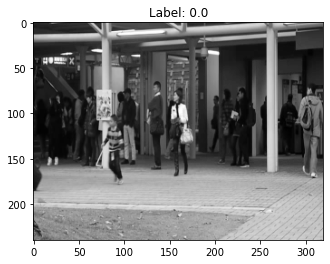

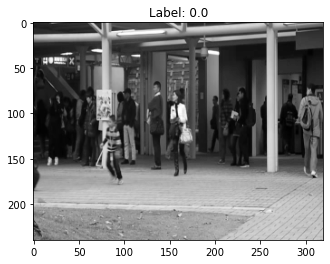

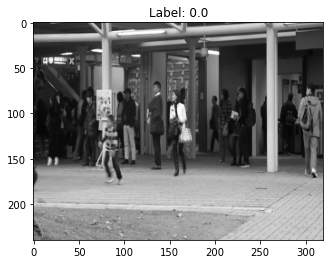

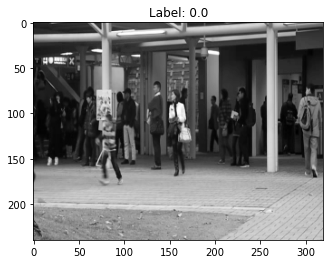

In [4]:
import matplotlib.pyplot as plt

# Choose an index to display
index_to_display = 3823

# Get the video clip frames and label at the selected index
selected_video_clip = video_data[index_to_display]
selected_label = labels[index_to_display]

# Display each frame in the video clip
for frame in selected_video_clip:
    plt.imshow(frame, cmap='gray')
    plt.title(f"Label: {selected_label}")
    plt.show()


In [5]:
#Rough

In [6]:
video_data.shape

(3824, 4, 240, 320)

In [7]:
labels

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import BinaryAccuracy
from keras.optimizers import Adam, SGD, Adadelta
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.models import Model
from keras.layers import Input, Conv3D, Conv3DTranspose, concatenate, BatchNormalization, Activation, Dropout, ConvLSTM2D
from tensorflow.keras.losses import MeanSquaredError

# Create and compile the model
model = Models._sEnDec_cnn_lstm(input_shape, dp)

# Create an optimizer
#optimizer = Adam() 

# Compile the model with binary cross-entropy loss and accuracy metric
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[binary_accuracy])

model.compile(optimizer=Adadelta(), loss=MeanSquaredError())

#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])




# Split data into train and test sets
split_ratio = 0.8
split_index = int(len(video_data) * split_ratio)

train_video = video_data[:split_index]
test_video = video_data[split_index:]

train_labels = labels[:split_index]
test_labels = labels[split_index:]


# Train the model
model.fit(train_video, train_video, batch_size=1, epochs=5, validation_split=0.3, verbose=1)

# Save the model to a file
model.save("anomaly_mdel.h5")

# Make reconstructions on test data
reconstructions = model.predict(test_video)

# You can visualize or analyze the input videos and their reconstructions as needed

[INFO] Creating sEnDec_cnn_lstm Model...

[INFO] Model Creation is Completed

Epoch 1/5
2141/2141 [==============================] - 207s 92ms/step - loss: 14344.5059 - val_loss: 14692.7285
Epoch 2/5
2141/2141 [==============================] - 196s 91ms/step - loss: 14307.5166 - val_loss: 14678.1406
Epoch 3/5
2141/2141 [==============================] - 197s 92ms/step - loss: 14296.0488 - val_loss: 14671.8887
Epoch 4/5
2141/2141 [==============================] - 195s 91ms/step - loss: 14291.3975 - val_loss: 14669.8779
Epoch 5/5
24/24 [==============================] - 23s 662ms/step


# Reconstruction plotting

24/24 [==============================] - 9s 411ms/step


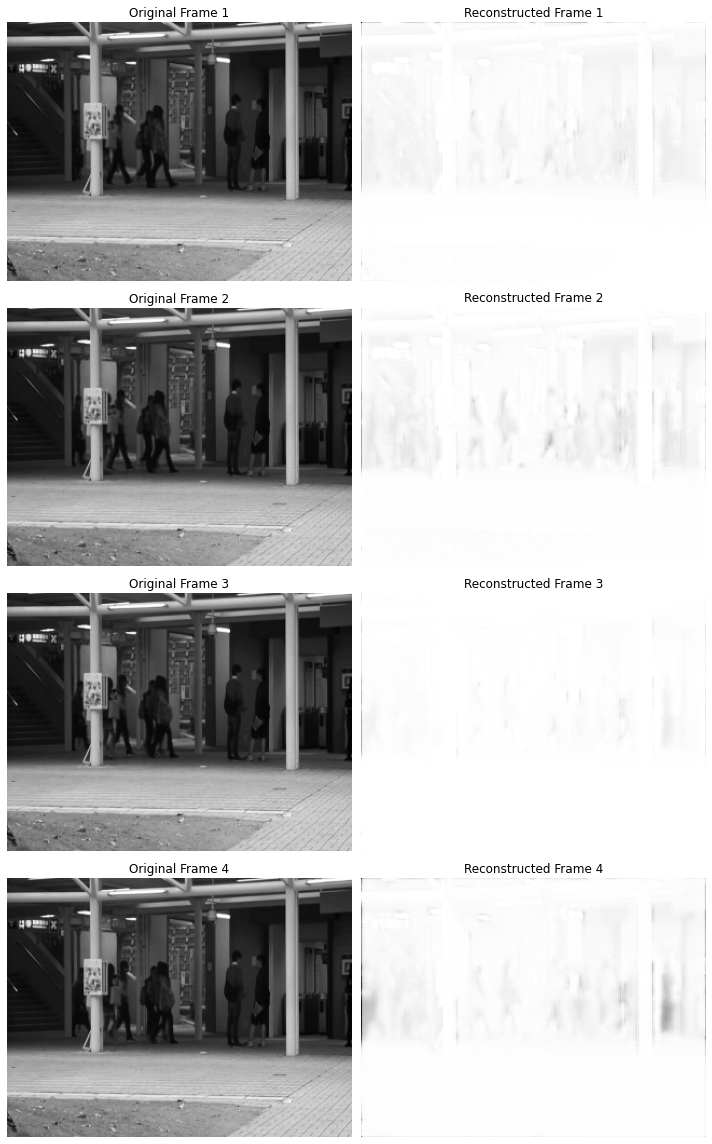

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Load the trained model


# Calculate reconstructions for video data
reconstructed_videos = model.predict(test_video)

# Choose a random video clip to visualize
sample_video_index = 1  # Change this to select a different video clip
sample_video_original = video_data[sample_video_index]
sample_video_reconstructed = reconstructed_videos[sample_video_index]

# Visualize original and reconstructed video frames
num_frames_to_visualize = min(num_frames, sample_video_original.shape[0])

plt.figure(figsize=(10, 4 * num_frames_to_visualize))
for i in range(num_frames_to_visualize):
    plt.subplot(num_frames_to_visualize, 2, 2 * i + 1)
    plt.imshow(sample_video_original[i].squeeze(), cmap='gray')
    plt.title(f'Original Frame {i+1}')
    plt.axis('off')

    plt.subplot(num_frames_to_visualize, 2, 2 * i + 2)
    plt.imshow(sample_video_reconstructed[i].squeeze(), cmap='gray')
    plt.title(f'Reconstructed Frame {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Calculate reconstruction errors

In [10]:
# Calculate reconstruction errors
reconstruction_errors = np.abs(sample_video_original - sample_video_reconstructed.squeeze())


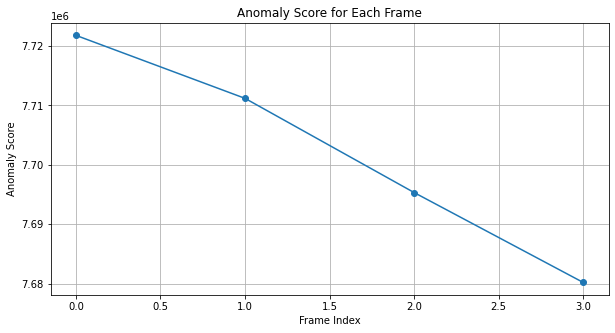

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate reconstruction errors
reconstruction_errors = np.abs(sample_video_original - sample_video_reconstructed.squeeze())

# Calculate the sum of errors along each frame
sum_errors_per_frame = np.sum(reconstruction_errors, axis=(1, 2))

# Plot the sum of errors using a line graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_frames_to_visualize), sum_errors_per_frame, marker='o')
plt.xlabel('Frame Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Score for Each Frame')
plt.grid(True)
plt.show()


# Visualize reconstruction errors

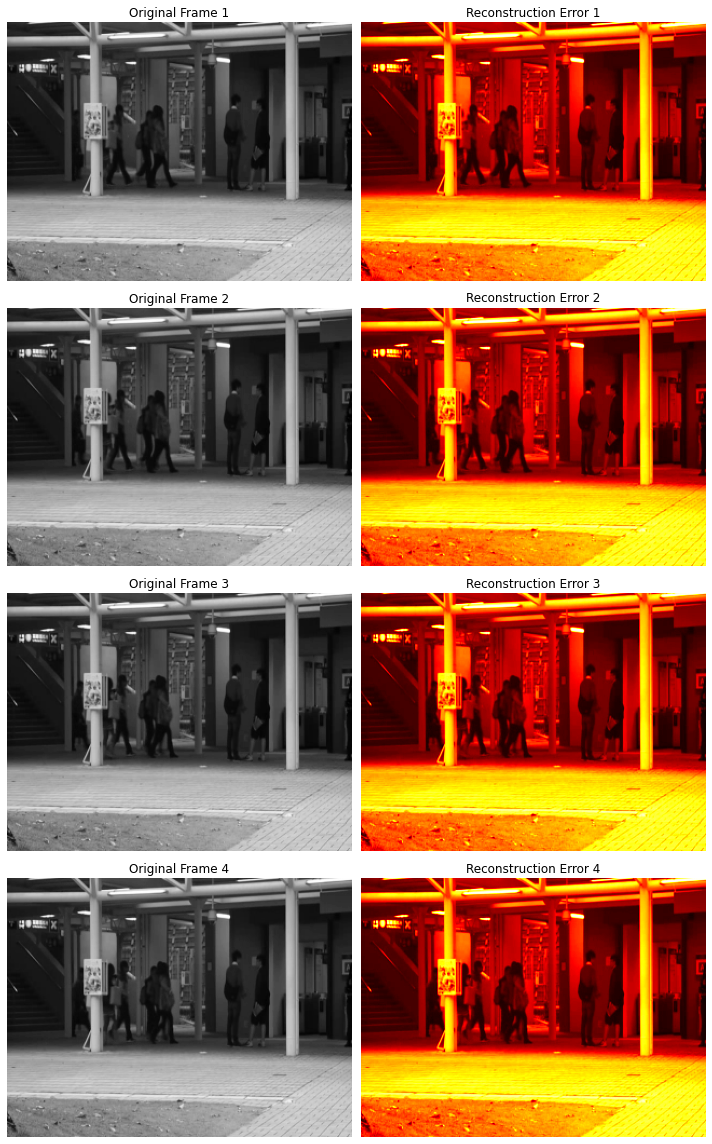

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate reconstruction errors
reconstruction_errors = np.abs(sample_video_original - sample_video_reconstructed.squeeze())

# Visualize reconstruction errors
plt.figure(figsize=(10, 4 * num_frames_to_visualize))
for i in range(num_frames_to_visualize):
    plt.subplot(num_frames_to_visualize, 2, 2 * i + 1)
    plt.imshow(sample_video_original[i].squeeze(), cmap='gray')
    plt.title(f'Original Frame {i+1}')
    plt.axis('off')

    plt.subplot(num_frames_to_visualize, 2, 2 * i + 2)
    plt.imshow(reconstruction_errors[i], cmap='hot')  # Using 'hot' colormap for visualization
    plt.title(f'Reconstruction Error {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Plot ROC curve

C:\Users\Armin\anaconda3\envs\conf\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


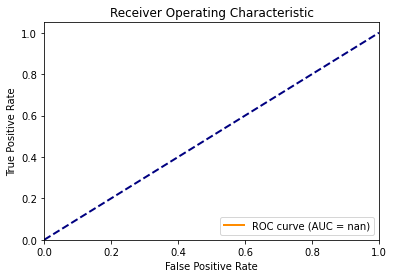

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate reconstruction errors
reconstruction_errors = np.abs(sample_video_original - sample_video_reconstructed.squeeze())

# Flatten the reconstruction errors
reconstruction_errors = reconstruction_errors.flatten()

# Assuming that you have ground truth labels for anomalies (0: normal, 1: anomaly)
# Replace 'anomaly_labels' with your actual labels

anomaly_labels = np.zeros(len(reconstruction_errors))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(anomaly_labels, reconstruction_errors)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()